In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
M = Base.classes.measurement
S = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
lastDate = session.query(M.date).all()[-1]
print(lastDate)
lastDate = lastDate[0]

('2017-08-23',)


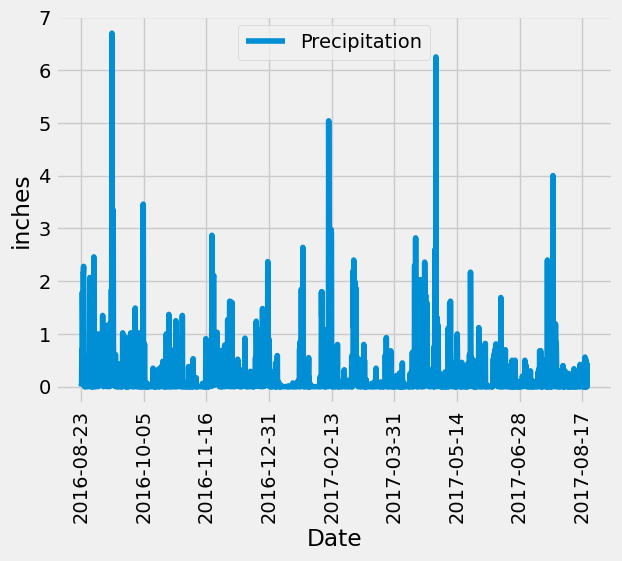

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
preYear = dt.datetime.strptime(lastDate,'%Y-%m-%d').date() - dt.timedelta(365)

# Perform a query to retrieve the date and precipitation scores
result = session.query(M.date,M.prcp).filter(M.date >= preYear).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
df = pd.DataFrame(result, columns = ["Date", "Precipitation"]).dropna().set_index('Date').sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot = 90, ylabel = "inches");

In [11]:
df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(S.name.distinct())).scalar()
total_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(
    M.station, func.count(M.station).label('total')
).join(S, S.station == M.station  # Correct this condition to match your relationship
).group_by(M.station
).order_by(func.count(M.station).desc()
).all()

for station in most_active_stations:
    print(f"Station: {station[0]}, Count: {station[1]}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#most_active_stations = 'the name of the most active station'  # Replace with the actual name
most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(
    func.min(M.tobs).label('lowest_temperature'),
    func.max(M.tobs).label('highest_temperature'),
    func.avg(M.tobs).label('average_temperature')
).filter(M.station == most_active_station_id).one()

# Print the results
print(f"Station: {most_active_station_id}")
print(f"Lowest Temperature: {temperature_stats.lowest_temperature}")
print(f"Highest Temperature: {temperature_stats.highest_temperature}")
print(f"Average Temperature: {temperature_stats.average_temperature:.2f}")


Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


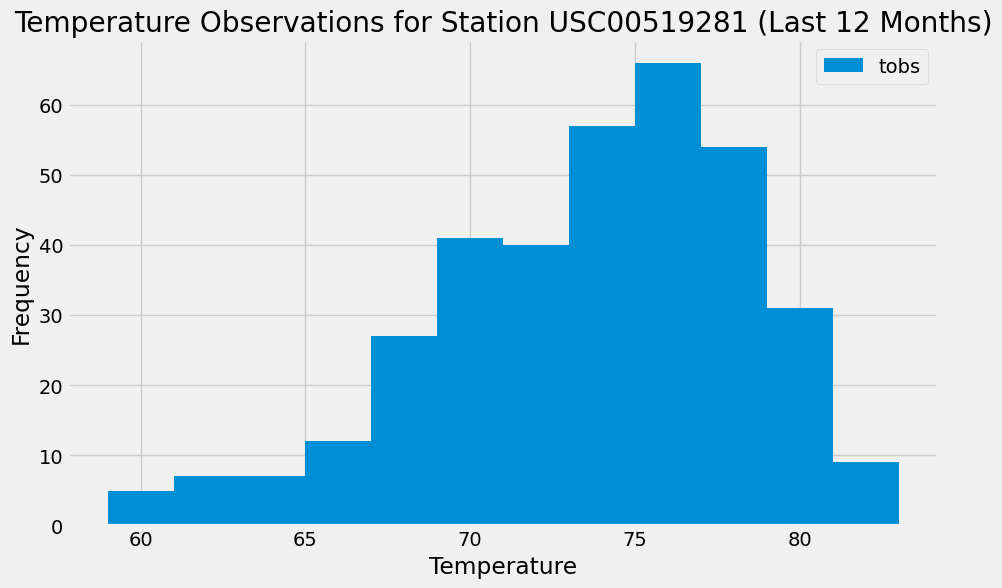

In [15]:
latest_date = session.query(func.max(M.date)).filter(M.station == most_active_station_id).scalar()

# Convert latest date string to datetime object
latest_date = dt.datetime.strptime(latest_date, "%Y-%m-%d")

# Calculate the date 12 months before the latest date
one_year_ago = latest_date - dt.timedelta(days=365)

# Query for the last 12 months of temperature data
temperature_data = session.query(M.tobs).\
                    filter(M.station == most_active_station_id).\
                    filter(M.date >= one_year_ago).\
                    order_by(M.date).all()

# Extract temperature observations from the query results
temperatures = [temp[0] for temp in temperature_data]

# Plotting the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)')
plt.savefig('temperature_observations.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# Close Session

In [16]:
# Close Session
session.close()